# Trajectory similarity
ref: [link](https://userguide.mdanalysis.org/stable/examples/analysis/trajectory_similarity/README.html)

A molecular dynamics trajectory with N atoms can be considered through a path through 3N-dimensional molecular configuration space. MDAnalysis contains a number of algorithms to compare the conformational ensembles of different trajectories. 

In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda

from MDAnalysis.tests.datafiles import (PSF, DCD, DCD2, GRO, XTC,
                                        PSF_NAMD_GBIS, DCD_NAMD_GBIS,
                                        PDB_small, CRD)
from MDAnalysis.analysis import psa


%matplotlib inline
# suppress some MDAnalysis warnings about writing PDB files
warnings.filterwarnings('ignore')

## Comparing the geometric similarity of trajectories

In [2]:
# load the trajectory
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
u3 = mda.Universe(GRO, XTC)
u4 = mda.Universe(PSF_NAMD_GBIS, DCD_NAMD_GBIS)
u5 = mda.Universe(PDB_small, CRD, PDB_small,
                  CRD, PDB_small, CRD, PDB_small)

ref = mda.Universe(PDB_small)


labels = ['DCD', 'DCD2', 'XTC', 'NAMD', 'mixed']
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory))

98 102 10


In [3]:
# aligning trajectories
CORE_sel = 'name CA and (resid 1:29 or resid 60:121 or resid 160:214)'

ps = psa.PSAnalysis([u1, u2, u3, u4, u5],
                    labels=labels,
                    reference=ref,
                    select=CORE_sel,
                    path_select='name CA')

In [4]:
# generating paths
ps.generate_paths(align=True, save=False, weights='mass')

### Hausdorff method

In [5]:
# We can compute the similarity of each path
# Hausdorff method
ps.run(metric='hausdorff')
ps.D

array([[ 0.        ,  1.33312648, 22.37206002,  2.04737477,  7.55204678],
       [ 1.33312648,  0.        , 22.3991666 ,  2.07957562,  7.55032598],
       [22.37206002, 22.3991666 ,  0.        , 22.42282661, 25.74534554],
       [ 2.04737477,  2.07957562, 22.42282661,  0.        ,  7.67052252],
       [ 7.55204678,  7.55032598, 25.74534554,  7.67052252,  0.        ]])

<Figure size 640x480 with 0 Axes>

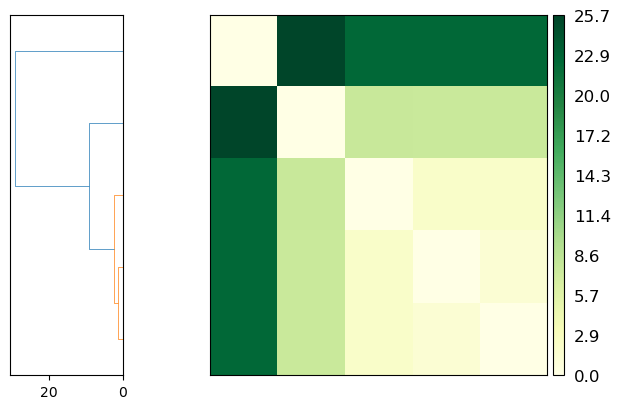

In [6]:
# plotting
fig = ps.plot(linkage='ward')

# psa.PSAnalysis provides two convenience methods for plotting this data. 
# The first is to plot a heat-map dendrogram from clustering the trajectories based on their path similarity. 
# You can use any clustering method supported by scipy.cluster.hierarchy.linkage; the default is ‘ward’.

<Figure size 640x480 with 0 Axes>

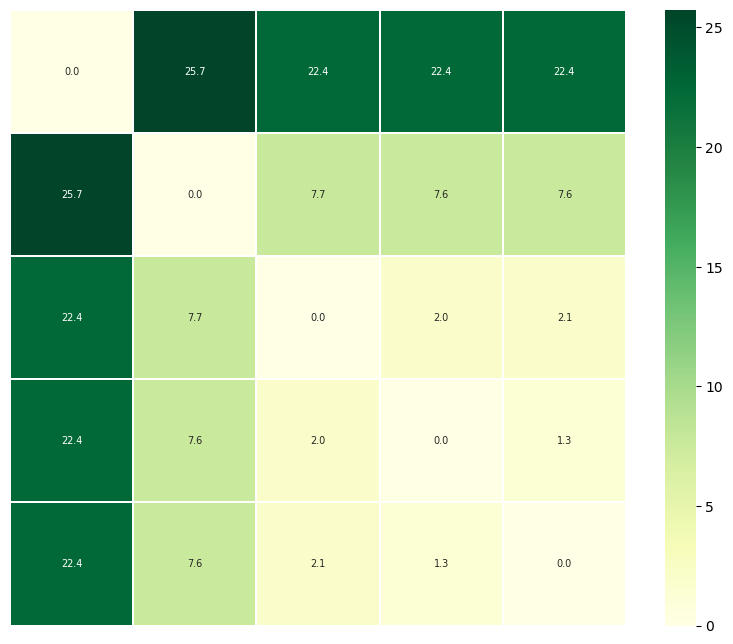

In [7]:
fig = ps.plot_annotated_heatmap(linkage='single')

### Discrete Fréchet distances

In [8]:
# Discrete Fréchet distances
ps.run(metric='discrete_frechet')
ps.D

array([[ 0.        ,  1.33312649, 22.37205967,  2.04737475,  7.55204694],
       [ 1.33312649,  0.        , 22.39916723,  2.07957565,  7.55032613],
       [22.37205967, 22.39916723,  0.        , 22.42282569, 25.74534511],
       [ 2.04737475,  2.07957565, 22.42282569,  0.        ,  7.67052241],
       [ 7.55204694,  7.55032613, 25.74534511,  7.67052241,  0.        ]])

<Figure size 640x480 with 0 Axes>

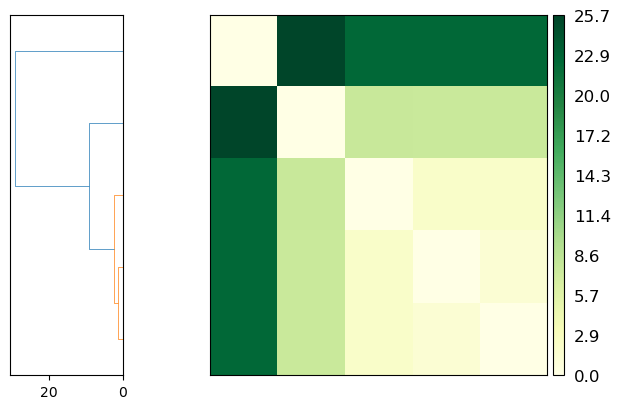

In [9]:
# plotting
fig = ps.plot(linkage='ward')

<Figure size 640x480 with 0 Axes>

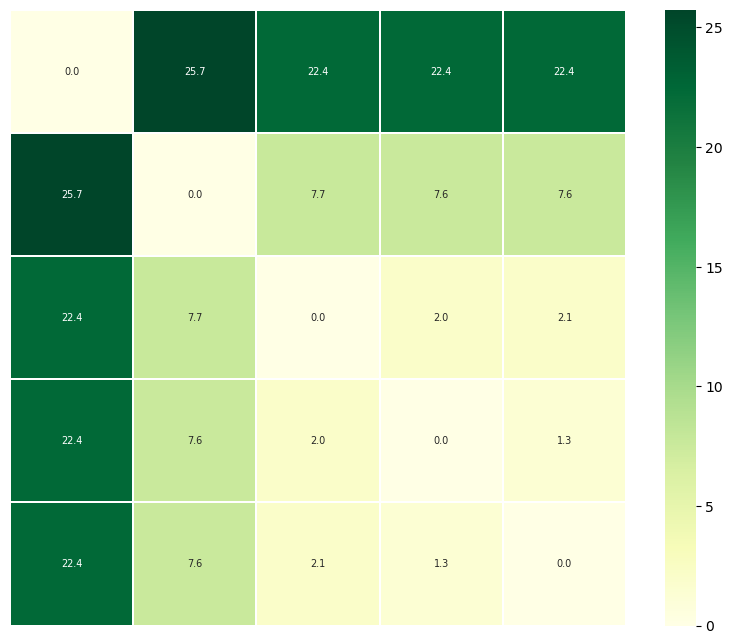

In [10]:
fig = ps.plot_annotated_heatmap(linkage='single')

## Calculating the Harmonic Ensemble Similarity between ensembles

In [11]:
from MDAnalysis.analysis import encore

In [12]:
# load the trajectory
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
u3 = mda.Universe(GRO, XTC)
u4 = mda.Universe(PSF_NAMD_GBIS, DCD_NAMD_GBIS)

labels = ['DCD', 'DCD2', 'XTC', 'NAMD']
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory))

98 102 10


In [13]:
# Calculating harmonic similarity
hes, details = encore.hes([u1, u2, u3, u4],
                         select='backbone',
                         align=True,
                         cov_estimator='shrinkage',
                         weights='mass')

for row in hes:
    for h in row:
        print("{:>10.1f}".format(h), end = ' ')
    print("")

In [ ]:
details["ensemble1_mean"].shape

In [ ]:
# plotting
fig, ax = plt.subplots()
im = plt.imshow(hes)
plt.xticks(np.arange(4), labels)
plt.yticks(np.arange(4), labels)
plt.title('Harmonic ensemble similarity')
cbar = fig.colorbar(im)

## Calculating the Clustering Ensemble Similarity between ensembles

In [ ]:
from MDAnalysis.analysis.encore.clustering import ClusteringMethod as clm

In [ ]:
# loading files
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
u3 = mda.Universe(PSF_NAMD_GBIS, DCD_NAMD_GBIS)

labels = ['DCD', 'DCD2', 'NAMD']
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory))

### Calculating clustering similarity with default settings


In [ ]:
ces0, details0 = encore.ces([u1, u2, u3])
print(ces0)

In [ ]:
cluster_collection = details0['clustering'][0]
print(type(cluster_collection))
print('We have found {} clusters'.format(len(cluster_collection)))

In [ ]:
first_cluster = cluster_collection.clusters[0]
print(first_cluster)
print(first_cluster.elements)
print('The ID of this cluster is:', first_cluster.id)
print('The centroid is', first_cluster.centroid)

In [ ]:
# plotting
fig0, ax0 = plt.subplots()
im0 = plt.imshow(ces0, vmax=np.log(2), vmin=0)
plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)
plt.title('Clustering ensemble similarity')
cbar0 = fig0.colorbar(im0)
cbar0.set_label('Jensen-Shannon divergence')

### Calculating clustering simliarity with one method

In [ ]:
clustering_method = clm.AffinityPropagationNative(preference=-1.0,
                                                  damping=0.9,
                                                  max_iter=200,
                                                  convergence_iter=30,
                                                  add_noise=True)

In [ ]:
ces1, details1 = encore.ces([u1, u2, u3],
                         select='name CA',
                         clustering_method=clustering_method,
                         ncores=4)

In [ ]:
# plotting
fig1, ax1 = plt.subplots()
im1 = plt.imshow(ces1, vmax=np.log(2), vmin=0)
plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)
plt.title('Clustering ensemble similarity')
cbar1 = fig1.colorbar(im1)
cbar1.set_label('Jensen-Shannon divergence')

### Calculating clustering similarity with multiple methods

In [ ]:
# Trying out different clustering parameters
km1 = clm.KMeans(12,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

km2 = clm.KMeans(6,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

In [ ]:
db1 = clm.DBSCAN(eps=0.5,
                 min_samples=5,
                 algorithm='auto',
                 leaf_size=30)

db2 = clm.DBSCAN(eps=1,
                 min_samples=5,
                 algorithm='auto',
                 leaf_size=30)

In [ ]:
ces2, details2 = encore.ces([u1, u2, u3],
                         select='name CA',
                         clustering_method=[km1, km2, db1, db2],
                         ncores=4)
print(len(ces2), len(details2['clustering']))

In [ ]:
# plotting 
titles = ['Kmeans 12 clusters', 'Kmeans 6 clusters', 'DBSCAN eps=0.5', 'DBSCAN eps=1']
fig2, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
for i, (data, title) in enumerate(zip(ces2, titles)):
    imi = axes[i].imshow(data, vmax=np.log(2), vmin=0)
    axes[i].set_xticks(np.arange(3))
    axes[i].set_xticklabels(labels)
    axes[i].set_title(title)
plt.yticks(np.arange(3), labels)
cbar2 = fig2.colorbar(imi, ax=axes.ravel().tolist())
cbar2.set_label('Jensen-Shannon divergence');

In [ ]:
n_db = len(details2['clustering'][-1])

print('Number of clusters in DBSCAN eps=1: {}'.format(n_db))

### Estimating the error in a clustering ensemble similarity

In [ ]:
avgs, stds = encore.ces([u1, u2, u3],
                         select='name CA',
                         clustering_method=clustering_method,
                         estimate_error=True,
                         ncores=4)
print("avgs: \n", avgs)
print("stds: \n", stds)

## Calculating the Dimension Reduction Ensemble Similarity between ensembles

## Evaluating convergence